# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.
We start by assuming the distribution of lightning in the inner core is Gaussian.

*We look at each basin separately. Below are the basin codes:
* ATL - Atlantic Ocean basin
* CPAC - 
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

## Code
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_processing.ipynb` notebook as `innercore_timebin_joined.csv`.

In [86]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches

In [3]:
# import data from csv file
innercore_data = pl.read_csv("data_pipeline/innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure"),  # Keep the column name as "pressure"
    pl.col("Intensification_Category").alias("Intensification_Category_5")
)

innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,TC_Category,Intensification_Category,log_lightning_count,Intensification_Category_5
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64,str
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.693147,"""Neutral"""
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0,"""Neutral"""
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0,"""Neutral"""
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0,"""Neutral"""
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0,"""Neutral"""


In [4]:
# Mapping categories into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
innercore_data = innercore_data.with_columns(
    innercore_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,TC_Category,Intensification_Category,log_lightning_count,Intensification_Category_5,Intensification_Category_3
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64,str,str
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.693147,"""Neutral""","""Neutral"""
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0,"""Neutral""","""Neutral"""
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0,"""Neutral""","""Neutral"""
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0,"""Neutral""","""Neutral"""
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0,"""Neutral""","""Neutral"""


In [15]:
# create dataframe for filtering later
storm_names = innercore_data[["storm_code", "storm_name"]].unique()

In [5]:
# IQR threshold function
def detect_bursts_iqr(group):
    Q1 = group['log_lightning_count'].quantile(0.25)
    Q3 = group['log_lightning_count'].quantile(0.75)
    IQR = Q3 - Q1

    # Set burst threshold for each cyclone individually
    threshold1 = Q3 + 1 * IQR
    threshold2 = Q3 + 1.5* IQR

    # Mark bursts specific to the cyclone
    group['burst_iqr_1'] = group['log_lightning_count'] > threshold1
    group['burst_iqr_2'] = group['log_lightning_count'] > threshold2
    group['iqr_1'] = threshold1
    group['iqr_2'] = threshold2
    return group

In [6]:
# MAD threshold function
def detect_bursts_mad(group):
    median_log = group['log_lightning_count'].median()
    mad_log = median_abs_deviation(group['log_lightning_count'])

    # Set burst threshold based on MAD for each cyclone
    threshold1 = median_log + 4 * mad_log
    threshold2 = median_log + 5 * mad_log

    # Mark bursts specific to the cyclone
    group['burst_mad_1'] = group['log_lightning_count'] > threshold1
    group['burst_mad_2'] = group['log_lightning_count'] > threshold2
    group['mad_1'] = threshold1
    group['mad_2'] = threshold2
    return group

In [7]:
#Log normal threshold function
def detect_bursts_lognormal(group):
     # Calculate the mean and standard deviation of the log-transformed lightning count
    mean_log = group['log_lightning_count'].mean()
    std_log = group['log_lightning_count'].std()

    # Set burst thresholds based on log-normal distribution (mean + 2σ and mean + 3σ)
    threshold1 = mean_log + 2 * std_log
    threshold2 = mean_log + 3 * std_log

    # Mark bursts specific to the cyclone
    group['burst_lognormal_1'] = group['log_lightning_count'] > threshold1
    group['burst_lognormal_2'] = group['log_lightning_count'] > threshold2
    group['lognormal_2sigma'] = threshold1
    group['lognormal_3sigma'] = threshold2
    return group

In [30]:
# apply functions to data
pd_data = innercore_data.to_pandas()
processed = pd_data.groupby(["storm_code", "Intensification_Category_3"]).apply(detect_bursts_iqr)
processed.reset_index(drop=True, inplace=True)
processed = processed.groupby(["storm_code","Intensification_Category_3"]).apply(detect_bursts_mad)
processed.reset_index(drop=True, inplace=True)
processed = processed.groupby(["storm_code","Intensification_Category_3"]).apply(detect_bursts_lognormal)
processed.reset_index(drop=True, inplace=True)
processed.sort_values("time_bin")
agg_result = processed.groupby(["storm_code", "Intensification_Category_3"]).agg(
    mad1_bursts=('burst_mad_1', 'sum'),
    mad2_bursts=('burst_mad_2', 'sum'),
    mad1_threshold=('mad_1', 'max'),
    mad2_threshold=('mad_2', 'max'),
    iqr1_bursts=('burst_iqr_1', 'sum'),
    iqr2_bursts=('burst_iqr_2', 'sum'),
    iqr1_threshold=('iqr_1', 'max'),
    iqr2_threshold=('iqr_2', 'max'),
    logn1_bursts=('burst_lognormal_1', 'sum'),
    logn2_bursts=('burst_lognormal_2', 'sum'),
    logn1_threshold=('lognormal_2sigma', 'max'),
    logn2_threshold=('lognormal_3sigma', 'max'),
    total_bins=('storm_code', 'count')
)
agg_result.reset_index(drop=False, inplace=True)
agg_result.head(10)

,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins
0,ATL_10_1,Intensifying,47,47,0.0,0.0,25,21,1.386294,1.732868,13,3,2.300315,3.212423,168
1,ATL_10_1,Neutral,23,23,0.0,0.0,23,23,0.000000,0.000000,16,6,1.063912,1.526130,220
2,ATL_10_1,Unidentified,5,5,0.0,0.0,5,5,0.000000,0.000000,5,2,0.632860,0.904742,48
3,ATL_10_1,Weakening,11,11,0.0,0.0,0,0,4.578312,5.722889,1,0,4.103690,5.574447,24
4,ATL_10_11,Intensifying,36,36,0.0,0.0,36,36,0.000000,0.000000,10,5,2.175495,3.090931,186
5,ATL_10_11,Neutral,44,44,0.0,0.0,44,44,0.000000,0.000000,17,11,1.736404,2.477530,289
6,ATL_10_11,Unidentified,4,4,0.0,0.0,4,4,0.000000,0.000000,4,2,0.647647,0.931145,48
7,ATL_10_11,Weakening,6,6,0.0,0.0,6,6,0.000000,0.000000,6,2,0.530860,0.773261,138
8,ATL_10_12,Intensifying,6,6,0.0,0.0,6,6,0.000000,0.000000,2,2,1.044149,1.504135,59
9,ATL_10_12,Neutral,44,44,0.0,0.0,44,44,0.000000,0.000000,20,6,3.053867,4.310356,237


In [ ]:
# apply functions to data(exclude 0 lightning count)
pd_data_0 = pd_data[pd_data['lightning_count'] != 0]
# remove unidentified intensification change cat from this eval - last 24 hours of each TC
pd_data_0 = pd_data_0[pd_data_0['Intensification_Category_3'] != "Unidentified"]

processed = pd_data_0.groupby(["storm_code", "Intensification_Category_3"]).apply(detect_bursts_iqr)
processed.reset_index(drop=True, inplace=True)
processed = processed.groupby(["storm_code","Intensification_Category_3"]).apply(detect_bursts_mad)
processed.reset_index(drop=True, inplace=True)
processed = processed.groupby(["storm_code","Intensification_Category_3"]).apply(detect_bursts_lognormal)
processed.reset_index(drop=True, inplace=True)

processed.sort_values(by=["storm_code", "time_bin"], inplace=True)
processed.reset_index(drop=True, inplace=True)

agg_result = processed.groupby(["storm_code", "Intensification_Category_3"]).agg(
    mad1_bursts=('burst_mad_1', 'sum'),
    mad2_bursts=('burst_mad_2', 'sum'),
    mad1_threshold=('mad_1', 'max'),
    mad2_threshold=('mad_2', 'max'),
    iqr1_bursts=('burst_iqr_1', 'sum'),
    iqr2_bursts=('burst_iqr_2', 'sum'),
    iqr1_threshold=('iqr_1', 'max'),
    iqr2_threshold=('iqr_2', 'max'),
    logn1_bursts=('burst_lognormal_1', 'sum'),
    logn2_bursts=('burst_lognormal_2', 'sum'),
    logn1_threshold=('lognormal_2sigma', 'max'),
    logn2_threshold=('lognormal_3sigma', 'max'),
    total_bins=('storm_code', 'count')
)
agg_result.reset_index(drop=False, inplace=True)
agg_result.head(10)

,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins
0,ATL_10_1,Intensifying,0,0,5.274601,6.190892,0,0,4.094345,4.944644,3,0,3.587593,4.530488,47
1,ATL_10_1,Neutral,1,0,2.720473,3.125938,4,1,2.302585,2.704945,1,0,2.691355,3.369977,23
2,ATL_10_1,Weakening,0,0,6.386995,7.342507,0,0,4.501197,5.165386,0,0,4.675037,5.744726,11
3,ATL_10_11,Intensifying,5,4,3.439678,3.988984,4,3,3.959678,4.776311,3,0,4.463637,5.805177,36
4,ATL_10_11,Neutral,8,6,2.720473,3.125938,3,1,3.845143,4.633142,2,0,3.915657,5.038826,44
5,ATL_10_11,Weakening,2,2,0.693147,0.693147,0,0,2.341066,2.753045,0,0,2.193993,2.761314,6
6,ATL_10_12,Intensifying,2,2,0.693147,0.693147,1,1,2.067583,2.411192,0,0,3.061869,3.982264,6
7,ATL_10_12,Neutral,0,0,6.675331,7.621571,0,0,5.695345,6.671241,1,0,5.436830,6.698533,44
8,ATL_10_12,Weakening,0,0,2.720473,3.125938,0,0,2.525729,2.983874,1,0,2.275353,2.820149,33
9,ATL_10_13,Intensifying,1,0,5.723757,6.668218,4,0,4.990433,5.963388,4,0,4.972158,6.332637,69


In [83]:
agg_result["mad1_prop"] = round((agg_result["mad1_bursts"]/agg_result["total_bins"])*100, 2)
agg_result["mad2_prop"] = round((agg_result["mad2_bursts"]/agg_result["total_bins"])*100, 2)
agg_result["iqr1_prop"] = round((agg_result["iqr1_bursts"]/agg_result["total_bins"])*100, 2)
agg_result["iqr2_prop"] = round((agg_result["iqr2_bursts"]/agg_result["total_bins"])*100, 2)
agg_result["logn1_prop"] = round((agg_result["logn1_bursts"]/agg_result["total_bins"])*100, 2)
agg_result["logn2_prop"] = round((agg_result["logn2_bursts"]/agg_result["total_bins"])*100, 2)
agg_result.head()

,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,Intensifying,0,0,5.274601,6.190892,0,0,4.094345,4.944644,...,0,3.587593,4.530488,47,0.00,0.00,0.00,0.00,6.38,0.0
1,ATL_10_1,Neutral,1,0,2.720473,3.125938,4,1,2.302585,2.704945,...,0,2.691355,3.369977,23,4.35,0.00,17.39,4.35,4.35,0.0
2,ATL_10_1,Weakening,0,0,6.386995,7.342507,0,0,4.501197,5.165386,...,0,4.675037,5.744726,11,0.00,0.00,0.00,0.00,0.00,0.0
3,ATL_10_11,Intensifying,5,4,3.439678,3.988984,4,3,3.959678,4.776311,...,0,4.463637,5.805177,36,13.89,11.11,11.11,8.33,8.33,0.0
4,ATL_10_11,Neutral,8,6,2.720473,3.125938,3,1,3.845143,4.633142,...,0,3.915657,5.038826,44,18.18,13.64,6.82,2.27,4.55,0.0


<Figure size 1000x500 with 0 Axes>

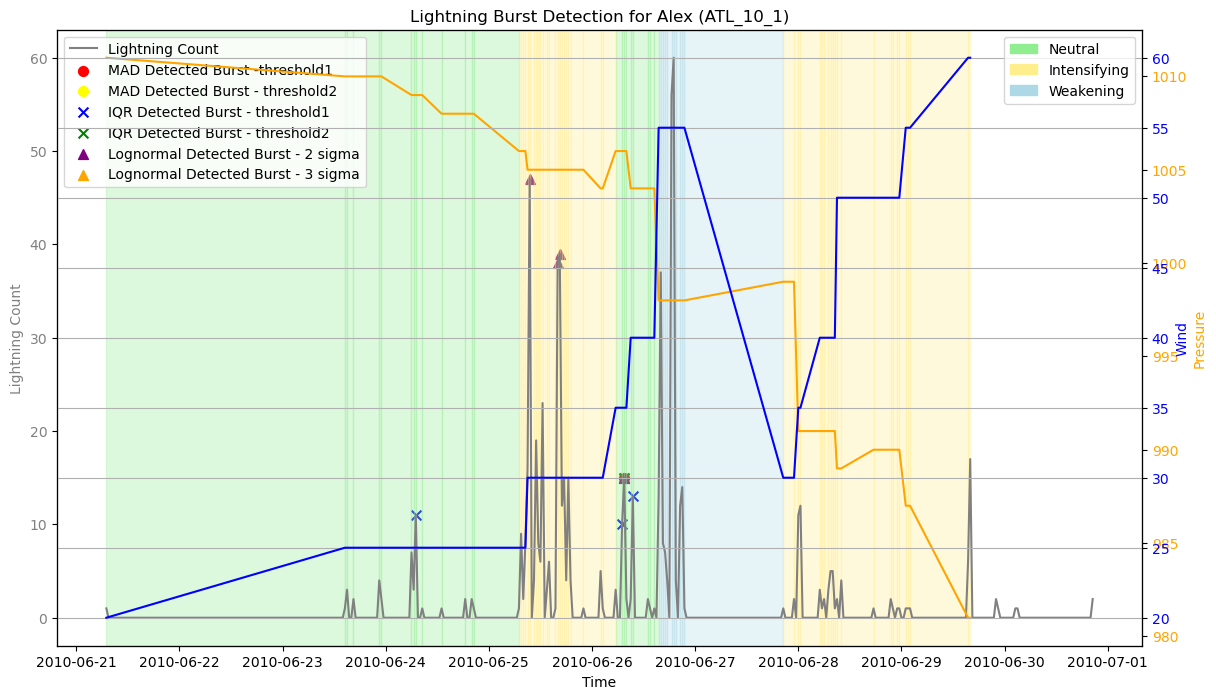

,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,Intensifying,0,0,5.274601,6.190892,0,0,4.094345,4.944644,...,0,3.587593,4.530488,47,0.00,0.0,0.00,0.00,6.38,0.0
1,ATL_10_1,Neutral,1,0,2.720473,3.125938,4,1,2.302585,2.704945,...,0,2.691355,3.369977,23,4.35,0.0,17.39,4.35,4.35,0.0
2,ATL_10_1,Weakening,0,0,6.386995,7.342507,0,0,4.501197,5.165386,...,0,4.675037,5.744726,11,0.00,0.0,0.00,0.00,0.00,0.0


In [91]:
# Select a specific cyclone to visualize
cyclone_id = 'ATL_10_1'
cyclone_name = storm_names.filter(pl.col("storm_code") == cyclone_id)["storm_name"].item()
df_cyclone = processed[processed['storm_code'] == cyclone_id]
lightning_data = innercore_data.filter(pl.col("storm_code") == cyclone_id)

plt.figure(figsize=(10, 5))

# Create first y-axis
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(lightning_data['time_bin'], lightning_data['lightning_count'], label='Lightning Count', color='gray')
ax1.set_xlabel("Time")
ax1.set_ylabel("Lightning Count", color="gray")
ax1.tick_params(axis='y', labelcolor="gray")

# Create second y-axis for pressure
ax2 = ax1.twinx()
ax2.plot(df_cyclone['time_bin'], df_cyclone['pressure'], label='Pressure', color='orange')
ax2.set_ylabel("Pressure", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# Create third y-axis for wind knot
ax2 = ax1.twinx()
ax2.plot(df_cyclone['time_bin'], df_cyclone['knots'], label='Wind', color='blue')
ax2.set_ylabel("Wind", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# Mark bursts detected by MAD
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_1']],
            color='red', label='MAD Detected Burst -threshold1', s=50, marker='o')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_2']],
            color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o')

# Mark bursts detected by IQR
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_1']],
            color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_2']],
            color='green', label='IQR Detected Burst - threshold2', s=50, marker='x')

# Mark bursts detected by lognormal threshold
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_1']],
            color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_2']],
            color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^')

for i in range(len(df_cyclone) - 1):
    category = df_cyclone['Intensification_Category_3'].iloc[i]

    if category == "Neutral":
        color = 'lightgreen'
    elif category == "Intensifying":
        color = '#FFEE8C'
    elif category == "Weakening":
        color = 'lightblue'
    else:
        color = 'white'

    ax1.axvspan(df_cyclone['time_bin'].iloc[i],
               df_cyclone['time_bin'].iloc[i + 1],
               color=color, alpha=0.3)
# Custom legend handles for background colors
green_patch = mpatches.Patch(color='lightgreen', label='Neutral')
yellow_patch = mpatches.Patch(color='#FFEE8C', label='Intensifying')
blue_patch = mpatches.Patch(color='lightblue', label='Weakening')

plt.xlabel('Time')
plt.title(f'Lightning Burst Detection for {cyclone_name} ({cyclone_id})')
ax1.legend()
ax2.legend(handles=[green_patch, yellow_patch, blue_patch], loc='upper right')
plt.xticks(visible=False)
plt.grid()
plt.show()

# print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

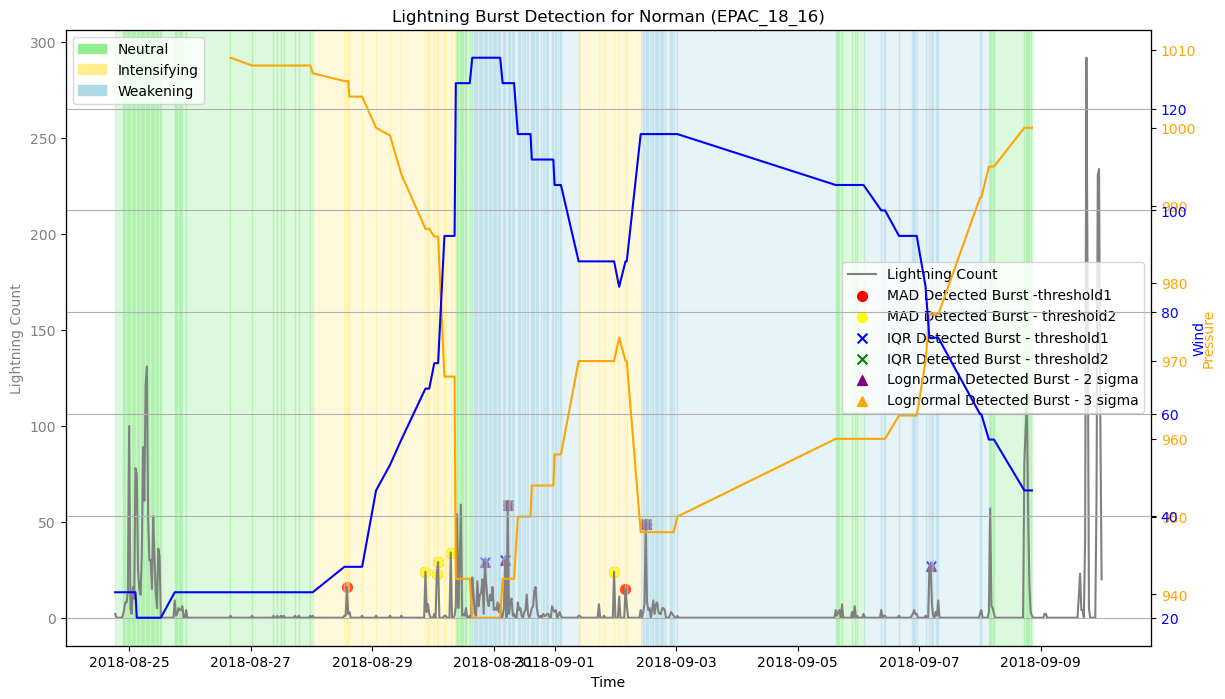

,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
408,EPAC_18_16,Intensifying,7,5,2.720473,3.125938,0,0,4.276666,5.172546,...,0,3.679694,4.726771,29,24.14,17.24,0.00,0.00,0.00,0.0
409,EPAC_18_16,Neutral,0,0,6.956962,8.209725,0,0,5.831882,7.015200,...,0,4.968249,6.318661,79,0.00,0.00,0.00,0.00,0.00,0.0
410,EPAC_18_16,Weakening,2,0,3.652740,4.163566,5,2,3.295837,3.845143,...,0,3.316032,4.131817,103,1.94,0.00,4.85,1.94,4.85,0.0


In [ ]:
# Select a specific cyclone to visualize
cyclone_id = 'EPAC_18_16'
cyclone_name = storm_names.filter(pl.col("storm_code") == cyclone_id)["storm_name"].item()
df_cyclone = processed[processed['storm_code'] == cyclone_id]
lightning_data = innercore_data.filter(pl.col("storm_code") == cyclone_id)

plt.figure(figsize=(10, 5))

# Create first y-axis
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(lightning_data['time_bin'], lightning_data['lightning_count'], label='Lightning Count', color='gray')
ax1.set_xlabel("Time")
ax1.set_ylabel("Lightning Count", color="gray")
ax1.tick_params(axis='y', labelcolor="gray")

# Create second y-axis for pressure
ax2 = ax1.twinx()
ax2.plot(df_cyclone['time_bin'], df_cyclone['pressure'], label='Pressure', color='orange')
ax2.set_ylabel("Pressure", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# Create third y-axis for wind knot
ax2 = ax1.twinx()
ax2.plot(df_cyclone['time_bin'], df_cyclone['knots'], label='Wind', color='blue')
ax2.set_ylabel("Wind", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# Mark bursts detected by MAD
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_1']],
            color='red', label='MAD Detected Burst -threshold1', s=50, marker='o')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_2']],
            color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o')

# Mark bursts detected by IQR
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_1']],
            color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_2']],
            color='green', label='IQR Detected Burst - threshold2', s=50, marker='x')

# Mark bursts detected by lognormal threshold
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_1']],
            color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_2']],
            color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^')

for i in range(len(df_cyclone) - 1):
    category = df_cyclone['Intensification_Category_3'].iloc[i]

    if category == "Neutral":
        color = 'lightgreen'
    elif category == "Intensifying":
        color = '#FFEE8C'
    elif category == "Weakening":
        color = 'lightblue'
    elif category == "Unidentified":
        color = 'white'
    else:
        color = 'red'

    ax1.axvspan(df_cyclone['time_bin'].iloc[i],
               df_cyclone['time_bin'].iloc[i + 1],
               color=color, alpha=0.3)
# Custom legend handles for background colors
green_patch = mpatches.Patch(color='lightgreen', label='Neutral')
yellow_patch = mpatches.Patch(color='#FFEE8C', label='Intensifying')
blue_patch = mpatches.Patch(color='lightblue', label='Weakening')

plt.xlabel('Time')
plt.title(f'Lightning Burst Detection for {cyclone_name} ({cyclone_id})')
ax1.legend()
ax2.legend(handles=[green_patch, yellow_patch, blue_patch], loc='upper left')
plt.xticks(visible=False)
plt.grid()
plt.show()

# print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

In [70]:
df_cyclone[~df_cyclone["Intensification_Category_3"].isin(["Intensifying", "Neutral", "Unidentified", "Weakening"])]

,time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,...,iqr_1,iqr_2,burst_mad_1,burst_mad_2,mad_1,mad_2,burst_lognormal_1,burst_lognormal_2,lognormal_2sigma,lognormal_3sigma


### EPAC Basin


In [75]:
epac_data = innercore_data.filter(pl.col("basin") == "EPAC")
epac_storm_codes = epac_data["storm_code"].unique()
epac_storm_codes.head()

storm_code
str
"""EPAC_12_3"""
"""EPAC_15_19"""
"""EPAC_11_3"""
"""EPAC_18_3"""
"""EPAC_20_18"""
"""EPAC_19_2"""
"""EPAC_14_11"""
"""EPAC_11_11"""
"""EPAC_18_20"""


In [ ]:
# basin-level summary of bursts
epac_agg_result = agg_result[agg_result["storm_code"].isin(epac_storm_codes)]

# median number of bursts by threshold, median threshold, median proportion
epac_agg_summary_median = epac_agg_result.drop(columns=("storm_code")).groupby("Intensification_Category_3").median()
epac_agg_summary_median

,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
Intensification_Category_3,,,,,,,,,,,,,,,,,,,
Intensifying,0.0,0.0,5.274601,6.186646,0.0,0.0,4.601176,5.522526,1.0,0.0,4.341602,5.570385,33.5,0.0,0.0,0.0,0.0,2.485,0.0
Neutral,0.0,0.0,5.538521,6.458899,0.0,0.0,4.821640,5.797791,0.0,0.0,4.681373,5.976382,31.5,0.0,0.0,0.0,0.0,0.000,0.0
Weakening,0.0,0.0,4.801509,5.534677,0.0,0.0,4.181672,4.750247,0.0,0.0,4.415519,5.477840,16.0,0.0,0.0,0.0,0.0,0.000,0.0


In [107]:
# mean number of bursts by threshold, mean threshold, mean proportion
epac_agg_summary = epac_agg_result.drop(columns=("storm_code")).groupby("Intensification_Category_3").mean()
epac_agg_summary

,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
Intensification_Category_3,,,,,,,,,,,,,,,,,,,
Intensifying,1.275000,0.887500,4.987892,5.775776,1.062500,0.450000,4.501650,5.358486,1.175000,0.0375,4.325284,5.470994,38.425000,6.204875,4.782875,4.268250,1.856125,3.139125,0.093625
Neutral,1.225000,0.875000,5.255162,6.074772,0.962500,0.300000,4.565247,5.414100,1.062500,0.0250,4.467871,5.631208,44.775000,4.910375,3.510375,3.430875,1.844625,2.200750,0.070625
Weakening,0.425532,0.106383,4.925303,5.624532,0.978723,0.297872,4.143676,4.821685,0.914894,0.0000,4.305202,5.364394,29.255319,1.942979,1.014681,3.243191,1.405319,2.025957,0.000000


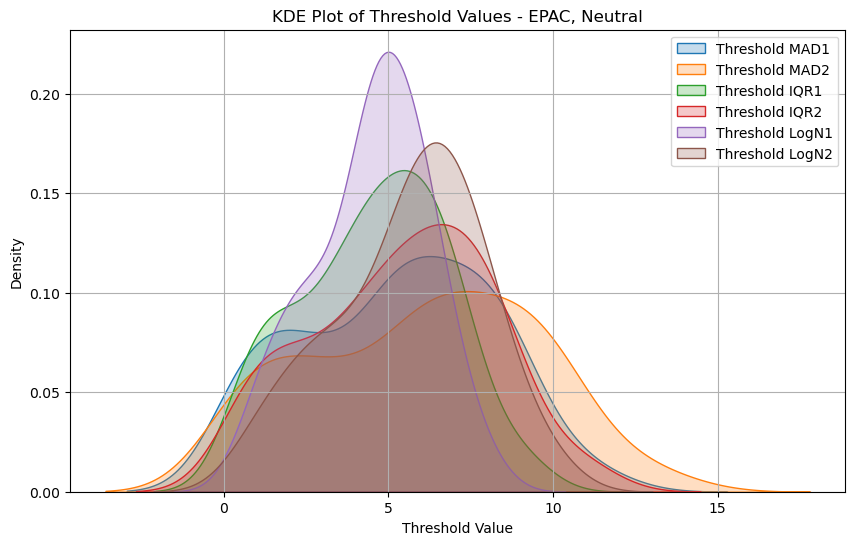

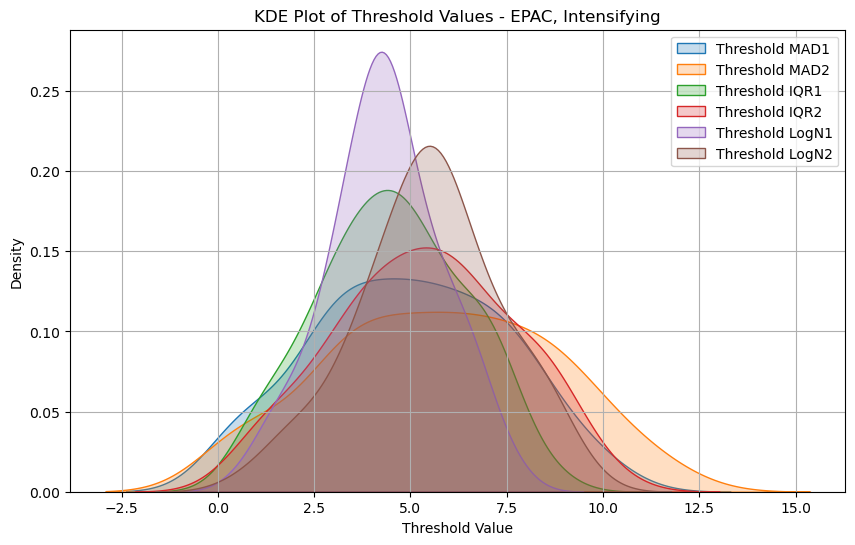

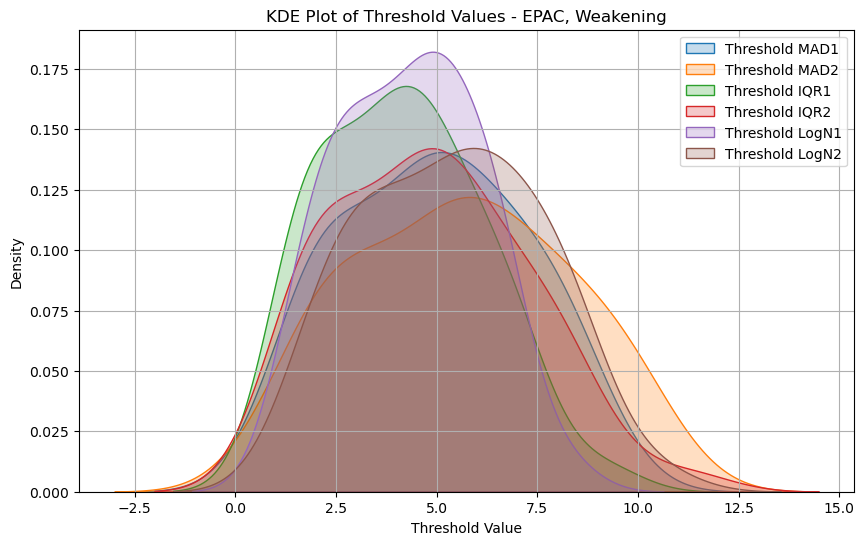

In [97]:
# Threshold value distribution
# Neutral bin
epac_agg_result_neutral = epac_agg_result[epac_agg_result["Intensification_Category_3"]=="Neutral"]
plt.figure(figsize=(10, 6))

sns.kdeplot(epac_agg_result_neutral['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(epac_agg_result_neutral['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(epac_agg_result_neutral['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(epac_agg_result_neutral['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(epac_agg_result_neutral['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(epac_agg_result_neutral['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - EPAC, Neutral')
plt.legend()
plt.grid()
plt.show()

# Intensifying bin
epac_agg_result_intensifying = epac_agg_result[epac_agg_result["Intensification_Category_3"]=="Intensifying"]
plt.figure(figsize=(10, 6))

sns.kdeplot(epac_agg_result_intensifying['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(epac_agg_result_intensifying['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(epac_agg_result_intensifying['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(epac_agg_result_intensifying['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(epac_agg_result_intensifying['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(epac_agg_result_intensifying['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - EPAC, Intensifying')
plt.legend()
plt.grid()
plt.show()

# Weakening bin
epac_agg_result_weakening = epac_agg_result[epac_agg_result["Intensification_Category_3"]=="Weakening"]
plt.figure(figsize=(10, 6))

sns.kdeplot(epac_agg_result_weakening['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(epac_agg_result_weakening['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(epac_agg_result_weakening['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(epac_agg_result_weakening['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(epac_agg_result_weakening['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(epac_agg_result_weakening['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - EPAC, Weakening')
plt.legend()
plt.grid()
plt.show()

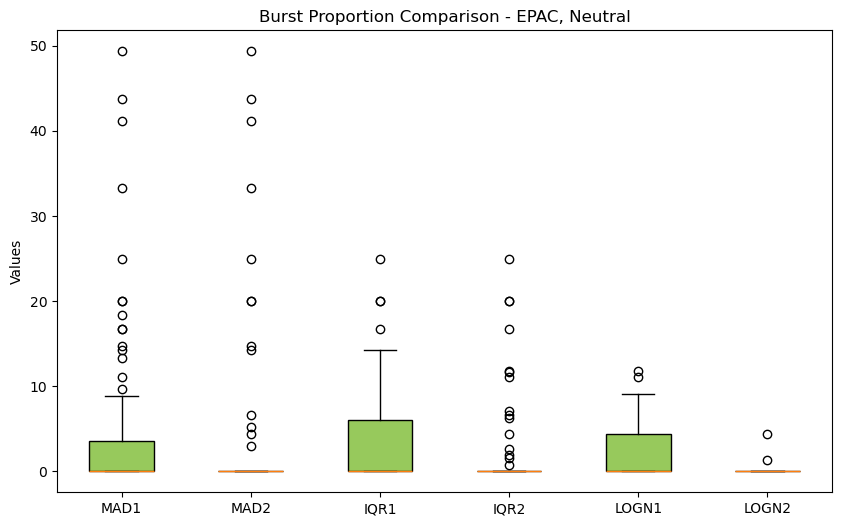

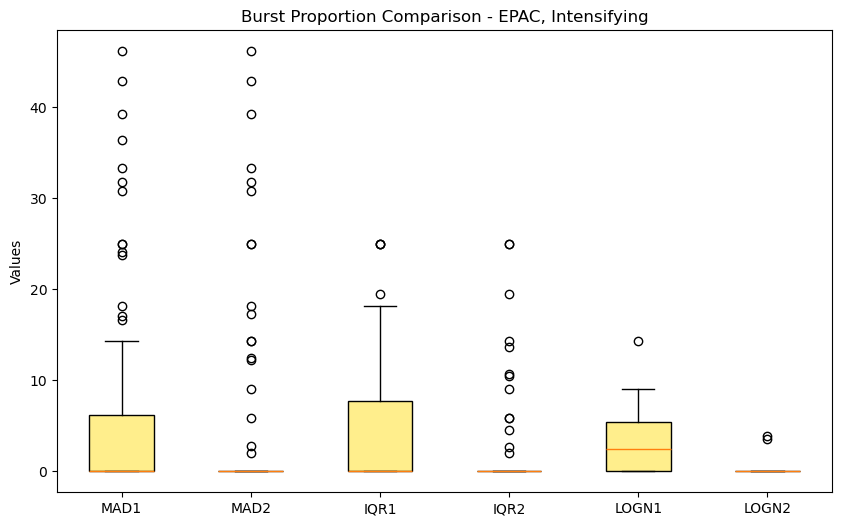

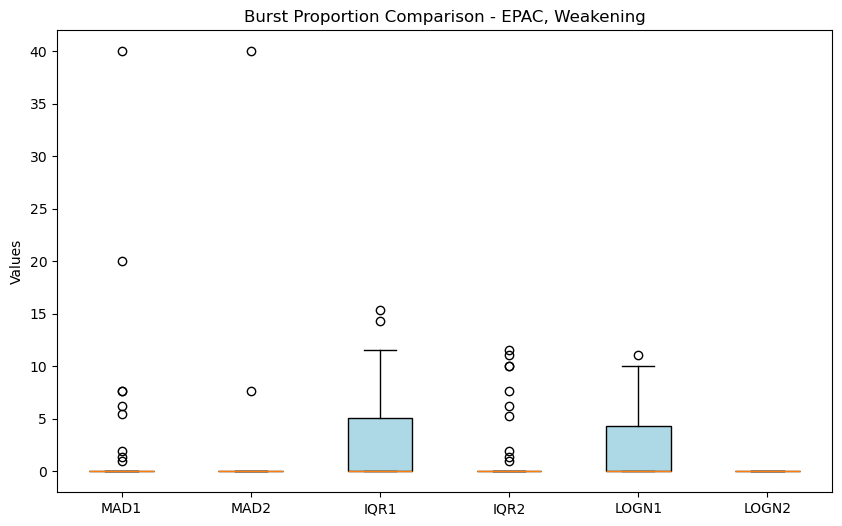

In [123]:
# burst proportion comparison - neutral
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_neutral['mad1_prop'], epac_agg_result_neutral['mad2_prop'], epac_agg_result_neutral['iqr1_prop'],
             epac_agg_result_neutral['iqr2_prop'], epac_agg_result_neutral['logn1_prop'], epac_agg_result_neutral['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#97c95c'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Neutral')
plt.ylabel('Values')

plt.show()

# burst proportion comparison - intensifying
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_intensifying['mad1_prop'], epac_agg_result_intensifying['mad2_prop'], epac_agg_result_intensifying['iqr1_prop'],
             epac_agg_result_intensifying['iqr2_prop'], epac_agg_result_intensifying['logn1_prop'], epac_agg_result_intensifying['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#FFEE8C'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Intensifying')
plt.ylabel('Values')

plt.show()

# burst proportion comparison - weakening
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_weakening['mad1_prop'], epac_agg_result_weakening['mad2_prop'], epac_agg_result_weakening['iqr1_prop'],
             epac_agg_result_weakening['iqr2_prop'], epac_agg_result_weakening['logn1_prop'], epac_agg_result_weakening['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Weakening')
plt.ylabel('Values')

plt.show()